In [ ]:
pip install yfinance pandas matplotlib seaborn

/tmp/ipython-input-22-1029715761.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date, progress=False, multi_level_index=False)


Data loaded successfully. Shape: (18870, 9)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Year', 'Month', 'Day']


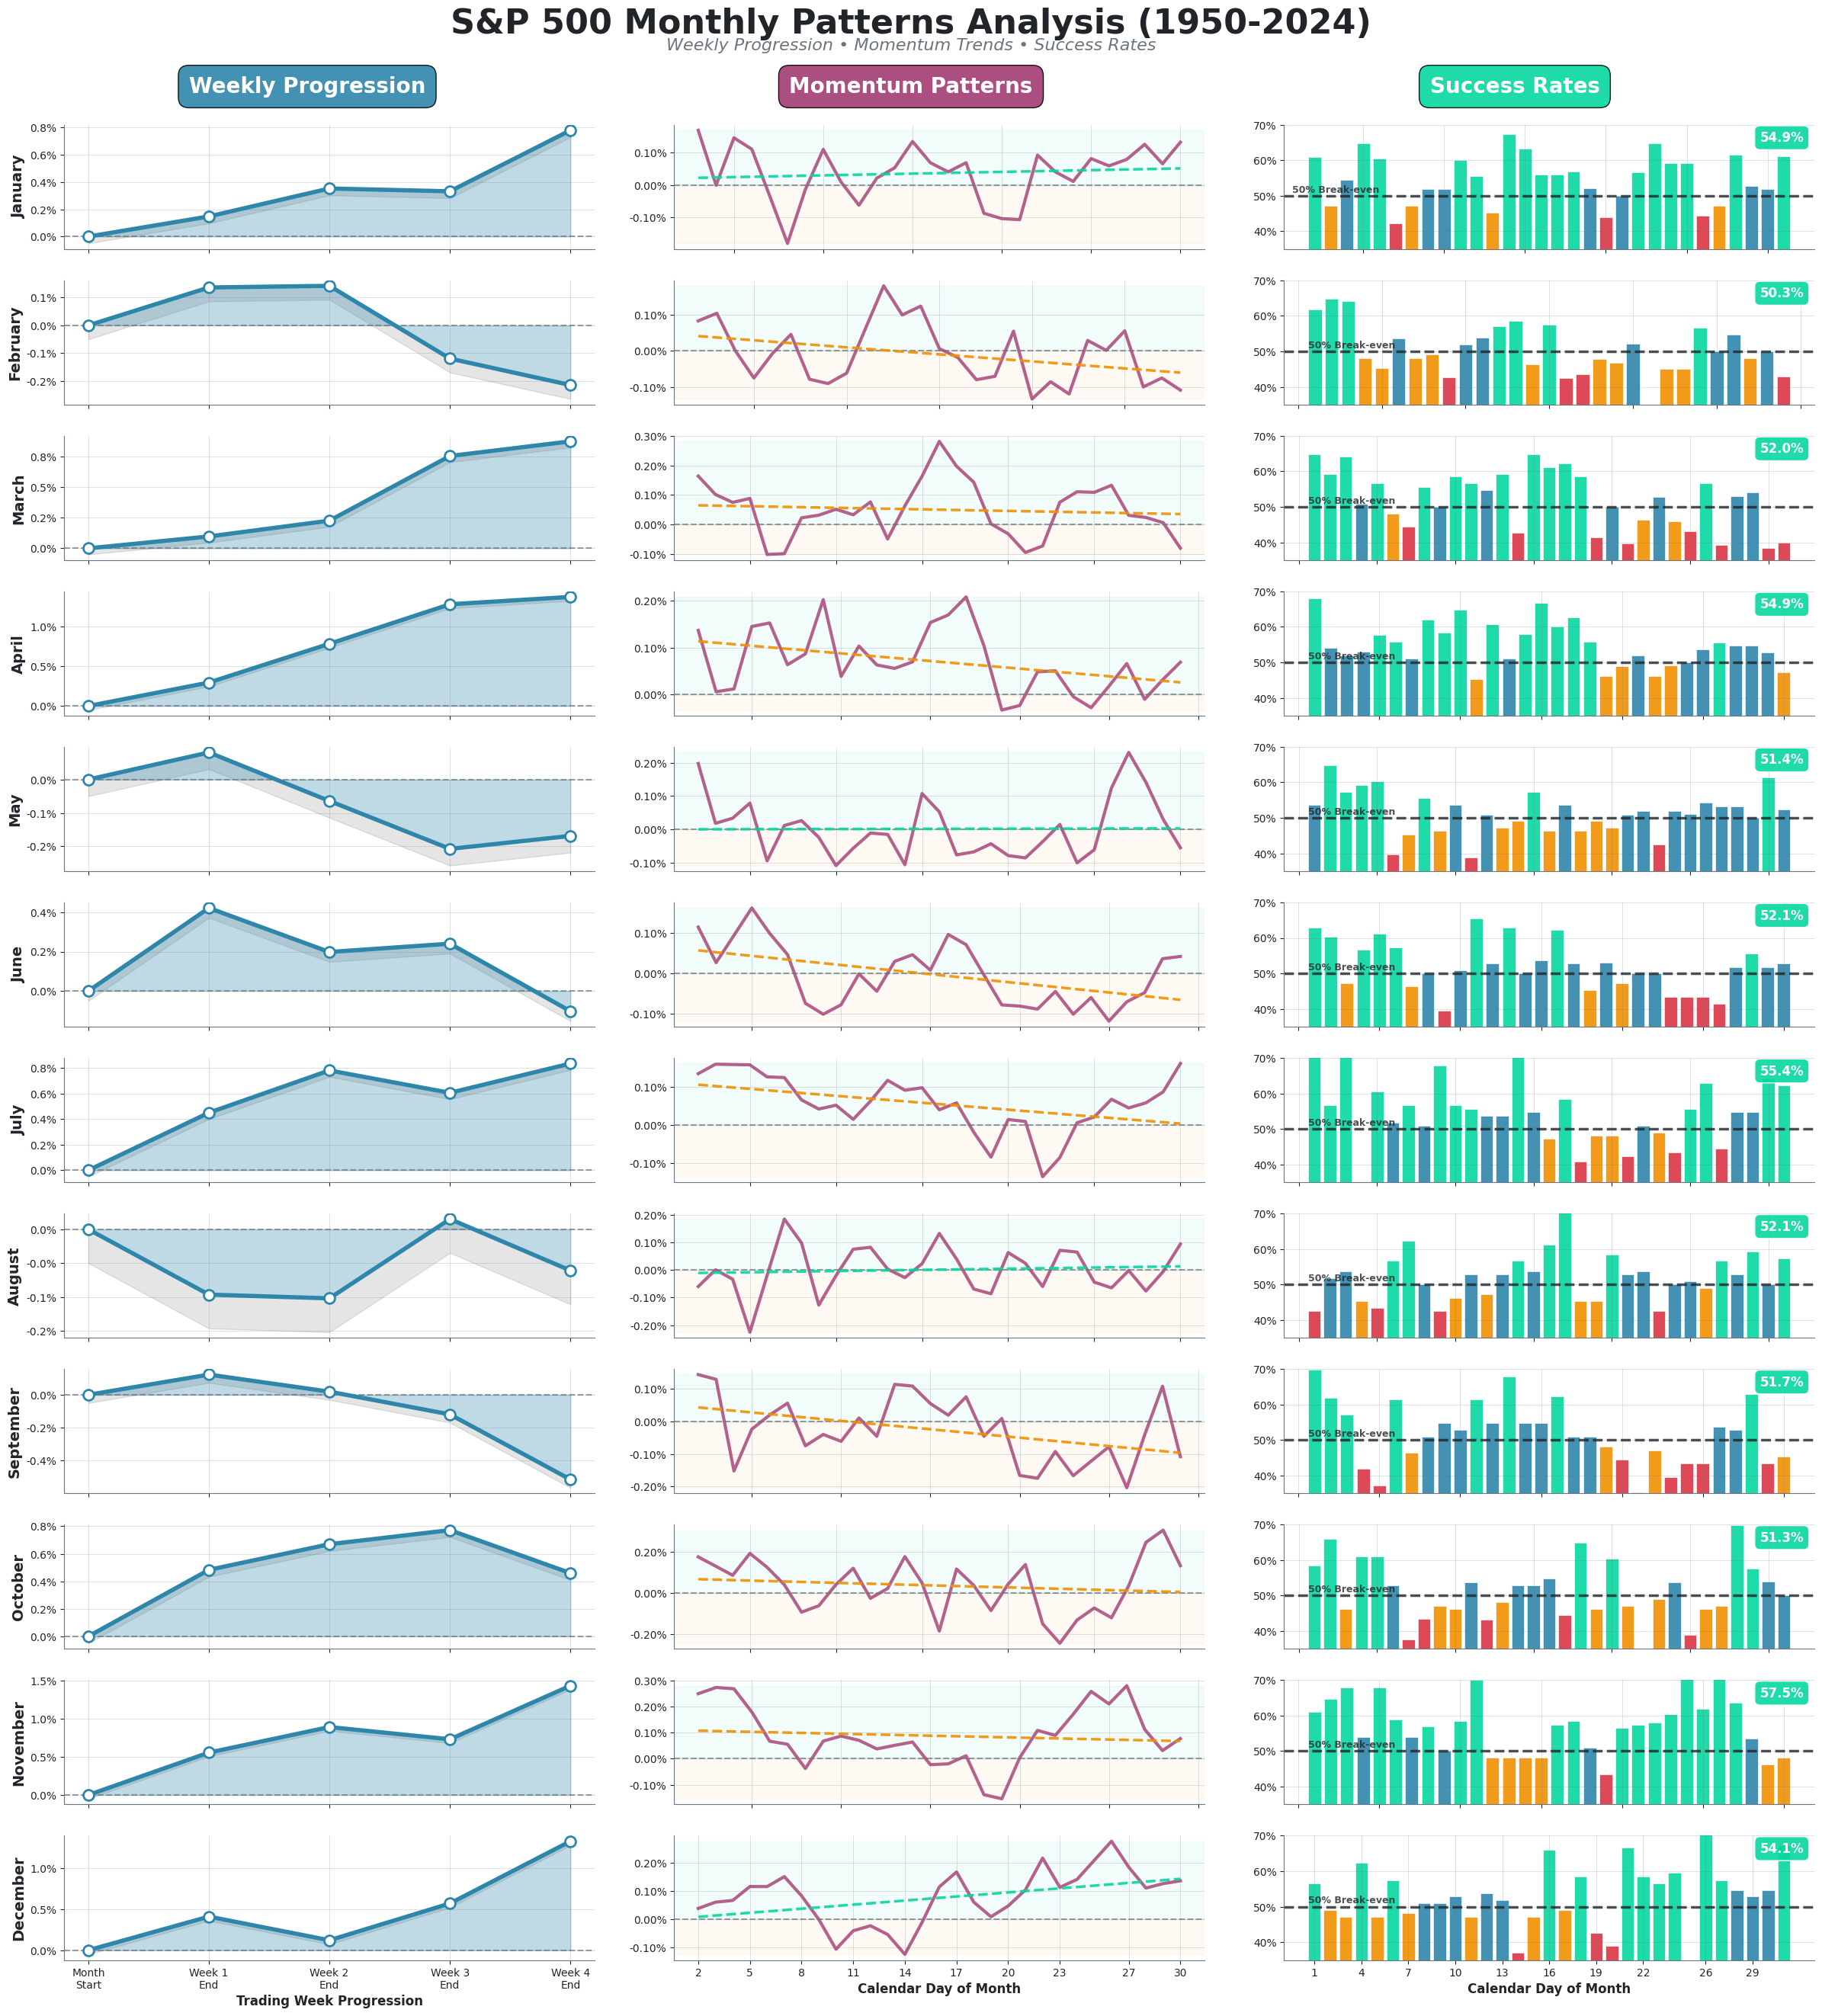


COMPREHENSIVE MONTHLY ANALYSIS SUMMARY

     January:
  Monthly Return:   0.78% | Best Week: Week 4 (+ 0.45%)
  Avg Momentum:    0.037% | Trend: Accelerating
  Win Rate:         54.9% | 1st Half:  55.2% | 2nd Half:  54.6%

    February:
  Monthly Return:   0.14% | Best Week: Week 1 (+ 0.14%)
  Avg Momentum:   -0.010% | Trend: Decelerating
  Win Rate:         50.3% | 1st Half:  53.2% | 2nd Half:  47.6%

       March:
  Monthly Return:   0.87% | Best Week: Week 3 (+ 0.53%)
  Avg Momentum:    0.050% | Trend: Stable
  Win Rate:         52.0% | 1st Half:  55.4% | 2nd Half:  48.9%

       April:
  Monthly Return:   1.37% | Best Week: Week 3 (+ 0.50%)
  Avg Momentum:    0.070% | Trend: Decelerating
  Win Rate:         54.9% | 1st Half:  57.2% | 2nd Half:  52.6%

         May:
  Monthly Return:   0.08% | Best Week: Week 1 (+ 0.08%)
  Avg Momentum:    0.001% | Trend: Stable
  Win Rate:         51.4% | 1st Half:  52.0% | 2nd Half:  51.0%

        June:
  Monthly Return:   0.42% | Best Week: Wee

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

# Download S&P 500 data
ticker = "^GSPC"
start_date = "1950-01-01"
end_date = "2024-12-31"

print("Downloading S&P 500 data...")
sp500 = yf.download(ticker, start=start_date, end=end_date, progress=False, multi_level_index=False)

# Handle potential multi-level columns from yfinance (shouldn't be needed now)
# Calculate daily returns
sp500['Daily_Return'] = sp500['Close'].pct_change()
sp500['Year'] = sp500.index.year
sp500['Month'] = sp500.index.month
sp500['Day'] = sp500.index.day

print(f"Data loaded successfully. Shape: {sp500.shape}")
print(f"Columns: {list(sp500.columns)}")

def analyze_month_simple(month_num, sp500_data):
    """Improved analysis with weekly progression, momentum, and win rates"""
    month_data = sp500_data[sp500_data['Month'] == month_num].copy()

    # 1. WEEKLY PROGRESSION ANALYSIS
    weekly_returns = {}

    # 2. MOMENTUM ANALYSIS
    momentum_by_day = {}

    # 3. WIN RATE ANALYSIS
    positive_days_by_day = {}

    years_processed = []

    for year in month_data['Year'].unique():
        year_month = month_data[month_data['Year'] == year].copy()

        # Filter out NaN values manually to avoid dropna
        valid_mask = year_month['Daily_Return'].notna() & year_month['Close'].notna()
        year_month = year_month[valid_mask]

        if len(year_month) < 15:  # Skip months with insufficient data
            continue

        years_processed.append(year)
        year_month = year_month.sort_index()

        # Calculate returns from first trading day of month
        if len(year_month) > 0:
            first_price = year_month['Close'].iloc[0]
            year_month['Month_Return'] = (year_month['Close'] / first_price) - 1

            # Assign trading day sequence
            year_month['Trading_Day'] = range(1, len(year_month) + 1)
            year_month['Trading_Week'] = ((year_month['Trading_Day'] - 1) // 5) + 1
            year_month['Day_of_Month'] = year_month.index.day

            # 1. Weekly progression based on trading weeks
            for week in range(1, 5):
                week_data = year_month[year_month['Trading_Week'] == week]
                if len(week_data) > 0:
                    week_return = week_data['Month_Return'].iloc[-1]
                    if week not in weekly_returns:
                        weekly_returns[week] = []
                    weekly_returns[week].append(week_return)

            # 2. Momentum analysis
            if len(year_month) >= 3:
                year_month['Rolling_Return'] = year_month['Daily_Return'].rolling(window=3, center=True).mean()

                for day, momentum in zip(year_month['Day_of_Month'], year_month['Rolling_Return']):
                    if not np.isnan(momentum):
                        if day not in momentum_by_day:
                            momentum_by_day[day] = []
                        momentum_by_day[day].append(momentum)

            # 3. Win rate analysis
            for day, daily_return in zip(year_month['Day_of_Month'], year_month['Daily_Return']):
                if not np.isnan(daily_return):
                    if day not in positive_days_by_day:
                        positive_days_by_day[day] = []
                    positive_days_by_day[day].append(1 if daily_return > 0 else 0)

    # Calculate averages and win rates
    weekly_avg_returns = {week: np.mean(returns)*100 for week, returns in weekly_returns.items()}
    momentum_avg = {day: np.mean(momentum)*100 for day, momentum in momentum_by_day.items()}
    win_rates = {day: np.mean(positive)*100 for day, positive in positive_days_by_day.items()}

    return weekly_avg_returns, momentum_avg, win_rates, years_processed

# Create visualization with improved aesthetics
plt.style.use('default')  # Reset to clean style
fig = plt.figure(figsize=(24, 28), facecolor='white')

# Modern color palette
colors = {
    'primary': '#2E86AB',      # Professional blue
    'secondary': '#A23B72',    # Accent purple
    'positive': '#06D6A0',     # Success green
    'negative': '#F18F01',     # Warning orange
    'neutral': '#6C757D',      # Neutral gray
    'background': '#F8F9FA',   # Light background
    'text': '#212529'          # Dark text
}

# Main title with modern styling
fig.suptitle('S&P 500 Monthly Patterns Analysis (1950-2024)',
             fontsize=32, fontweight='bold', y=0.975, color=colors['text'])

# Subtitle
fig.text(0.5, 0.955, 'Weekly Progression • Momentum Trends • Success Rates',
         fontsize=16, ha='center', style='italic', color=colors['neutral'])

# Column headers with modern styling and colored backgrounds
header_props = dict(fontsize=20, fontweight='bold', color='white',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor=colors['primary'], alpha=0.9))
fig.text(0.17, 0.935, 'Weekly Progression', ha='center', **header_props)

header_props['bbox']['facecolor'] = colors['secondary']
fig.text(0.5, 0.935, 'Momentum Patterns', ha='center', **header_props)

header_props['bbox']['facecolor'] = colors['positive']
fig.text(0.83, 0.935, 'Success Rates', ha='center', **header_props)

month_names = [calendar.month_name[i] for i in range(1, 13)]

for month_num in range(1, 13):
    # Create subplots with better spacing
    ax1 = plt.subplot(12, 3, (month_num-1)*3 + 1)  # Weekly
    ax2 = plt.subplot(12, 3, (month_num-1)*3 + 2)  # Momentum
    ax3 = plt.subplot(12, 3, (month_num-1)*3 + 3)  # Win rate

    weekly_returns, momentum, win_rates, years = analyze_month_simple(month_num, sp500)

    if not years:
        for ax in [ax1, ax2, ax3]:
            ax.text(0.5, 0.5, 'Insufficient Data', ha='center', va='center',
                   fontsize=12, color=colors['neutral'])
            ax.set_facecolor(colors['background'])
        continue

    # Set clean background for all subplots
    for ax in [ax1, ax2, ax3]:
        ax.set_facecolor('white')
        ax.grid(True, alpha=0.3, linewidth=0.5, color=colors['neutral'])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color(colors['neutral'])
        ax.spines['bottom'].set_color(colors['neutral'])

    # 1. WEEKLY PROGRESSION CHART - Enhanced styling
    weeks = list(weekly_returns.keys())
    week_values = list(weekly_returns.values())

    if weeks:
        plot_weeks = [0] + weeks
        plot_values = [0] + week_values

        # Create gradient effect
        ax1.plot(plot_weeks, plot_values, 'o-', linewidth=4, markersize=10,
                color=colors['primary'], markerfacecolor='white', markeredgewidth=2,
                markeredgecolor=colors['primary'], zorder=3)

        # Fill with gradient-like effect
        ax1.fill_between(plot_weeks, 0, plot_values, alpha=0.3,
                        color=colors['primary'], zorder=1)

        # Add subtle shadow effect
        ax1.fill_between(plot_weeks, [v-0.05 for v in plot_values], plot_values,
                        alpha=0.1, color='black', zorder=0)

        ax1.set_xticks(plot_weeks)

        # Enhanced x-axis labels
        if month_num == 12:
            week_labels = ['Month\nStart'] + [f'Week {w}\nEnd' for w in weeks]
            ax1.set_xticklabels(week_labels, rotation=0, fontsize=11,
                              color=colors['text'], fontweight='500')
            ax1.set_xlabel('Trading Week Progression', fontsize=12,
                          fontweight='bold', color=colors['text'])
        else:
            ax1.set_xticklabels([])

        ax1.axhline(y=0, color=colors['neutral'], linewidth=1.5, alpha=0.7, linestyle='--')

        # Enhanced y-axis label
        ax1.set_ylabel(f'{month_names[month_num-1]}', fontweight='bold',
                      fontsize=14, color=colors['text'])
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}%'))
        ax1.tick_params(colors=colors['text'], labelsize=10)

    # 2. MOMENTUM CHART - Enhanced styling
    if momentum:
        days = sorted(momentum.keys())
        mom_values = [momentum[day] for day in days]

        # Create smooth line with better styling
        ax2.plot(days, mom_values, linewidth=3, color=colors['secondary'],
                alpha=0.8, zorder=2)

        # Add trend line with different style
        if len(days) > 5:
            z = np.polyfit(days, mom_values, 1)
            p = np.poly1d(z)
            trend_color = colors['positive'] if z[0] > 0 else colors['negative']
            ax2.plot(days, p(days), "--", color=trend_color, alpha=0.9,
                    linewidth=2.5, zorder=3)

        # Color-coded background zones
        ax2.axhspan(0, max(mom_values) if mom_values else 0.1, alpha=0.05,
                   color=colors['positive'], zorder=0)
        ax2.axhspan(min(mom_values) if mom_values else -0.1, 0, alpha=0.05,
                   color=colors['negative'], zorder=0)

        ax2.axhline(y=0, color=colors['neutral'], linewidth=1.5, alpha=0.7, linestyle='--')

        if month_num != 12:
            ax2.set_xticklabels([])
        else:
            ax2.set_xlabel('Calendar Day of Month', fontsize=12,
                          fontweight='bold', color=colors['text'])
            if len(days) > 15:
                step = max(1, len(days) // 8)
                ax2.set_xticks(days[::step])

        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}%'))
        ax2.tick_params(colors=colors['text'], labelsize=10)

    # 3. WIN RATE CHART - Enhanced styling
    if win_rates:
        days = sorted(win_rates.keys())
        win_values = [win_rates[day] for day in days]

        # Enhanced color scheme for bars
        colors_bars = []
        for w in win_values:
            if w >= 55:
                colors_bars.append(colors['positive'])
            elif w >= 50:
                colors_bars.append(colors['primary'])
            elif w >= 45:
                colors_bars.append(colors['negative'])
            else:
                colors_bars.append('#DC3545')  # Strong red for very poor performance

        bars = ax3.bar(days, win_values, color=colors_bars, alpha=0.8,
                      width=0.8, edgecolor='white', linewidth=0.5)

        # Add subtle gradient effect to bars
        for bar, color in zip(bars, colors_bars):
            bar.set_facecolor(color)
            bar.set_alpha(0.9)

        # Enhanced reference line
        ax3.axhline(y=50, color=colors['text'], linewidth=2.5,
                   linestyle='--', alpha=0.8, zorder=2)
        ax3.text(max(days)*0.02, 51, '50% Break-even', fontsize=9,
                color=colors['text'], alpha=0.8, fontweight='bold')

        if month_num != 12:
            ax3.set_xticklabels([])
        else:
            ax3.set_xlabel('Calendar Day of Month', fontsize=12,
                          fontweight='bold', color=colors['text'])
            if len(days) > 15:
                step = max(1, len(days) // 8)
                ax3.set_xticks(days[::step])

        ax3.set_ylim(35, 70)
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
        ax3.tick_params(colors=colors['text'], labelsize=10)

        # Enhanced info box
        avg_win_rate = np.mean(win_values)
        box_color = colors['positive'] if avg_win_rate >= 50 else colors['negative']
        ax3.text(0.98, 0.95, f'{avg_win_rate:.1f}%',
                transform=ax3.transAxes, fontsize=12, fontweight='bold',
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.4', facecolor=box_color,
                         alpha=0.9, edgecolor='white', linewidth=1),
                color='white')

# Improved layout with better spacing
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.06, hspace=0.25, wspace=0.15)

# Add subtle background pattern
fig.patch.set_facecolor('white')
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("COMPREHENSIVE MONTHLY ANALYSIS SUMMARY")
print("="*80)

for month_num in range(1, 13):
    weekly_returns, momentum, win_rates, years = analyze_month_simple(month_num, sp500)

    if not years:
        continue

    month_name = calendar.month_name[month_num]

    # Calculate summary metrics
    if weekly_returns:
        # Total monthly return is the final week's cumulative return
        total_monthly_return = max(weekly_returns.values()) if weekly_returns else 0

        # Calculate incremental weekly contributions
        sorted_weeks = sorted(weekly_returns.keys())
        weekly_contributions = {}
        for i, week in enumerate(sorted_weeks):
            if i == 0:
                weekly_contributions[week] = weekly_returns[week]
            else:
                weekly_contributions[week] = weekly_returns[week] - weekly_returns[sorted_weeks[i-1]]

        best_week = max(weekly_contributions, key=weekly_contributions.get)
        best_week_contribution = weekly_contributions[best_week]

    if momentum:
        avg_momentum = np.mean(list(momentum.values()))
        days = sorted(momentum.keys())
        mom_values = [momentum[day] for day in days]
        if len(days) > 5:
            momentum_trend = np.corrcoef(days, mom_values)[0,1]
        else:
            momentum_trend = 0

    if win_rates:
        avg_win_rate = np.mean(list(win_rates.values()))

        # First half vs second half win rates
        mid_day = max(win_rates.keys()) // 2
        first_half_days = [d for d in win_rates.keys() if d <= mid_day]
        second_half_days = [d for d in win_rates.keys() if d > mid_day]

        first_half_win = np.mean([win_rates[d] for d in first_half_days]) if first_half_days else 0
        second_half_win = np.mean([win_rates[d] for d in second_half_days]) if second_half_days else 0

    print(f"\n{month_name:>12}:")
    print(f"  Monthly Return: {total_monthly_return:>6.2f}% | Best Week: Week {best_week} (+{best_week_contribution:>5.2f}%)")
    print(f"  Avg Momentum:   {avg_momentum:>6.3f}% | Trend: {'Accelerating' if momentum_trend > 0.1 else 'Decelerating' if momentum_trend < -0.1 else 'Stable'}")
    print(f"  Win Rate:       {avg_win_rate:>6.1f}% | 1st Half: {first_half_win:>5.1f}% | 2nd Half: {second_half_win:>5.1f}%")

print(f"\nAnalysis covers {len(years)} years ({min(years)}-{max(years)})")
print("="*80)
print("\nX-Axis Explanations:")
print("• Weekly Progression: From month start to end of each trading week (Mon-Fri)")
print("• Momentum: Calendar days showing 3-day rolling average of daily returns")
print("• Win Rate: Calendar days showing % of years with positive returns on that day")
print("\nKey Insights:")
print("- Weekly Progression: Shows how returns accumulate by trading week (5 days each)")
print("- Momentum: 3-day rolling average reveals acceleration/deceleration patterns")
print("- Win Rates: Percentage of positive days - more robust to outliers")